In [1]:
import pandas as pd
import numpy as np
import cleaning_tools as ct
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../../all_currencies.csv')

In [3]:
coinsAll = ct.unique(df['Symbol'])
datesAll = ct.unique(df['Date'])

## Load Numpy Arrays with Prices and Caps

In [4]:
T=len(datesAll)
N=len(coinsAll)

timeCoins = np.zeros(N)
endDate = []
    
T = 1020 ### this is a good number to pick
Pall = np.zeros((N,T))*np.nan
CAPall = np.zeros((N,T))*np.nan

for i in range(N):
    ind_coin = np.where(df['Symbol']==coinsAll[i])[0]
    if len(ind_coin)>=T:
        Pall[i,]=df['Close'][ind_coin[-T:]]
        CAPall[i,]=df['Market Cap'][ind_coin[-T:]]
        dates=df['Date'][ind_coin[-T:]]

## Clean the Data of Bad Points

In [5]:
ind_complete_cases = np.where(ct.complete_cases(Pall))[0]
P = Pall[ind_complete_cases,:]
CAP = CAPall[ind_complete_cases,:]
coins = [coinsAll[i] for i in ind_complete_cases]

ind_complete_cases = np.where(ct.complete_cases(CAP))[0]
P = P[ind_complete_cases,:]
CAP = CAP[ind_complete_cases,:]
coins = [coins[i] for i in ind_complete_cases]

R = np.diff(P,axis=1)/P[:,0:-1]

N,T = R.shape

##  Principal Component Analysis

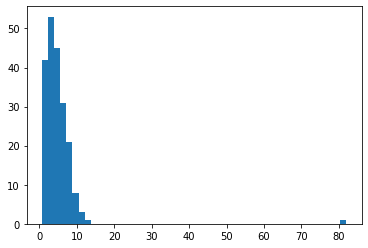

In [16]:
##### eigenportfolio estimation:
sigma = np.std(R,axis=1)

Rsort_norm = StandardScaler().fit_transform(R.T).T
u,s,v = np.linalg.svd(Rsort_norm)
    
plt.hist((s**2)/N,bins = 50);

## Principal Eigenportfolio

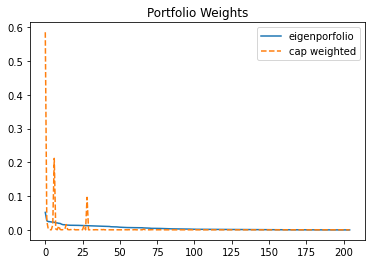

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


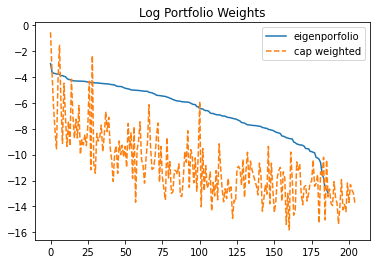

    eigenportfolio           cap
0              BTC  6.478321e+10
1              LTC  2.917656e+09
2             DOGE  2.133390e+08
3              PPC  3.279894e+07
4             CLAM  7.899399e+06
5             DASH  1.564551e+09
6              ETH  2.343666e+10
7              BTS  2.616549e+08
8              BLK  1.194293e+07
9              XMR  1.262994e+09
10             NXT  9.478813e+07
11             XPM  9.551512e+06
12            GAME  6.660655e+07
13             DMD  9.814124e+06
14             XLM  1.727231e+09
15             FCT  1.027862e+08
16           BURST  1.777729e+07
17             SYS  7.891366e+07
18             NMC  1.826443e+07
19              SC  2.255413e+08
20             NVC  5.097252e+06
21             IOC  1.604968e+07
22             GRC  1.068586e+07
23             XCP  2.408412e+07
24             UNO  1.015416e+07
25             VTC  4.781580e+07
26             XEM  1.475735e+09
27           START  1.557604e+06
28             XRP  1.064520e+10
29        

In [19]:
pi = np.zeros((N,N))

for t in range(N):
    pi[:,t]= u[:,t]/sigma
    pi[:,t]= pi[:,t]/np.sum(pi[:,t])

ix = np.argsort(pi[:,0])[::-1]
mean_cap = np.mean(CAP,axis=1)
ix_cap = np.argsort(mean_cap)[::-1]
pi1_sort = pi[ix,0]

plt.plot(pi1_sort,label='eigenporfolio')
plt.plot(mean_cap[ix]/np.sum(mean_cap),linestyle='--',label='cap weighted')
plt.title('Portfolio Weights')
plt.legend()
plt.show()

plt.plot(np.log(pi1_sort),label='eigenporfolio')
plt.plot(np.log(mean_cap[ix]/np.sum(mean_cap)),linestyle='--',label='cap weighted')
plt.title('Log Portfolio Weights')
plt.legend()
plt.show()

coins_ep = [coins[i] for i in ix]
    
s1 = pd.Series(coins_ep,name='eigenportfolio')
s2 = pd.Series(mean_cap[ix],name='cap')

DF = pd.concat([s1,s2], axis=1)

pd.set_option('display.max_rows', None)
print(DF)

## Compute Cap-Weighted Portfolio

In [8]:
Rm = np.zeros(T)
Pm = np.zeros(T+1)
Pm[0]=100
for t in range(T):
    wt = CAP[:,t]/np.sum(CAP[:,t])
    Rm[t]=np.sum(wt*R[:,t])
    Pm[t+1]=Pm[t]*(1+Rm[t])
  

## Check for Co-Integration

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

Z = np.zeros((N,T+1))
h_adf = 100*np.ones(N)
h_pp = 100*np.ones(N)
L_adf = np.zeros(N)

##### add ETFs to Engle-Granger Test, SPY only
for i in range(N):
    if min(P[i,])>0:
        c = np.ones(T+1)
        t = np.arange(0,T+1)
        X = np.column_stack((c,t,np.log(Pm)))
        Y =  sm.OLS(np.log(P[i,]), X).fit()
        Z[i,] = Y.resid
        DF = adfuller(Z[i,],regression="ct")#,maxlag = int(np.power(len(Z[i,])-1,1/3)))
        h_adf[i] = DF[1]
        L_adf[i] = DF[0]
        PP = PhillipsPerron(Z[i,])
        h_pp[i] = PP.pvalue

## PLOT THE TIME SERIES of CO-INTEGRATED RESIDUALS

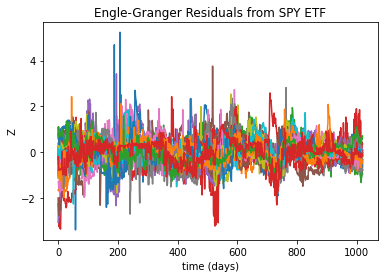

In [10]:
ind = np.where(h_adf<.01)[0]

plt.plot(Z[ind,:].T)
plt.xlabel('time (days)') 
plt.ylabel('Z') 
plt.title("Engle-Granger Residuals from SPY ETF")
plt.show() 

number of co-integrated stocks: 34


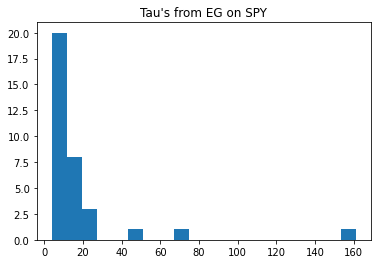

In [11]:
Nz = len(ind)
theta = np.zeros(Nz)
kappa = np.zeros(Nz)
sigma = np.zeros(Nz)
for i in range(Nz): 
    theta[i] = np.mean(Z[ind[i],])
    kappa[i] = -np.log(np.corrcoef(Z[ind[i],1:],Z[ind[i],0:-1])[0,1])*252
    sigma[i] = np.sqrt(2*kappa[i])*np.std(Z[ind[i],])


tau = 252/kappa
print("number of co-integrated stocks:",len(ind))
plt.hist(tau,bins=20)
plt.title("Tau's from EG on SPY")
plt.show()



In [12]:
ind_fastest = np.where(tau<24)[0]

coins_fastest = [coins[i] for i in ind[ind_fastest]]
tau_fastest = [round(tau[i],4) for i in ind_fastest ]
sd = 252*np.sqrt(2*tau/T)
sd_fastest = [round(sd[i],4) for i in ind_fastest]
cap_fastest = [round(mean_cap[i],4) for i in ind_fastest]

s1 = pd.Series(coins_fastest,name='coin')
s2 = pd.Series(tau_fastest,name='tau')
s3 = pd.Series(sd_fastest,name='std err')
s4 = pd.Series(cap_fastest,name='cap')

DF =pd.concat([s1,s2,s3,s4], axis=1)

print(DF)

     coin      tau  std err           cap
0    8BIT   5.4011  25.9460  1.724289e+06
1     ADC  13.8262  41.5126  5.416289e+05
2    BITS  15.7028  44.2402  1.184822e+05
3     BLC  15.1913  43.5137  1.916986e+05
4     BSC   7.5291  30.6338  3.266353e+06
5     BTB   7.5482  30.6726  2.868372e+06
6     BYC  22.0058  52.3718  6.367153e+04
7    CANN  15.8541  44.4528  3.230966e+04
8     CCN   8.0381  31.6522  1.604809e+06
9     EFL  18.3473  47.8206  1.421560e+07
10    EMD  13.5735  41.1314  1.330272e+06
11    EUC   7.8820  31.3435  2.990560e+05
12   INFX  20.4795  50.5229  2.595352e+07
13   KOBO   4.3945  23.4036  3.069690e+08
14    NKA   3.8782  21.9858  7.233684e+06
15   NTRN  12.6618  39.7261  3.227749e+05
16   PLNC   6.8515  29.2228  1.499125e+05
17    PXI  10.4169  36.0328  1.194293e+07
18    SLG   4.5942  23.9295  4.368562e+07
19  SUPER   4.8801  24.6628  6.576183e+05
20    TGC   9.1943  33.8522  4.380117e+05
21    THC  15.8947  44.5097  1.492960e+04
22    TIT  10.0546  35.4007  5.064